## Model 2. DecisionTree

#### Without hyperparametrics tunning

In [3]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score, f1_score, recall_score, precision_score, roc_auc_score,roc_curve



In [4]:
with open('Dataset_After_Preprocessing.pkl', 'rb') as f:
    Dataset_After_Preprocessing = pickle.load(f)

In [5]:

# Memisahkan fitur dan target
X = Dataset_After_Preprocessing.drop(columns=['Exited'])
y = Dataset_After_Preprocessing['Exited']

# Membagi data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train is:", X_train.shape)
print("Shape of X_test is:", X_test.shape)
print("Shape of y_train is:", y_train.shape)
print("Shape of y_test is:", y_test.shape)

# Mengubah tipe data target menjadi integer
y_train = y_train.astype('int')
y_test = y_test.astype('int')


Shape of X_train is: (12545, 16)
Shape of X_test is: (3137, 16)
Shape of y_train is: (12545,)
Shape of y_test is: (3137,)


In [6]:

# Melatih model Logistic Regression
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

# Melakukan prediksi pada data training dan testing
y_train_pred_dt = decision_tree.predict(X_train)
y_test_pred_dt = decision_tree.predict(X_test)

### Metric Evaluation

####  Accuracy, Precision, Recall, dan F1

In [7]:


# Menghitung dan mencetak metrik evaluasi untuk data training
acc_train_dt = round(accuracy_score(y_train, y_train_pred_dt) * 100, 2)
acc_test_dt = round(accuracy_score(y_test, y_test_pred_dt) * 100, 2)
f1_dt = round(f1_score(y_test, y_test_pred_dt, average="micro") * 100, 2)
recall_dt = round(recall_score(y_test, y_test_pred_dt, average="micro") * 100, 2)
precision_dt = round(precision_score(y_test, y_test_pred_dt, average="micro") * 100, 2)


y_score_dt = decision_tree.predict_proba(X_test)[:,1] # Menggunakan probabilitas kelas positif
roc_auc_dt = roc_auc_score(y_test, y_score_dt)

# Cross-validation
cv_scores_dt= cross_val_score(decision_tree, X_train, y_train, cv=5, scoring='accuracy')


In [8]:
print("__________________________________Hasil Evaluasi Model Decision Tree_________________________________________________")

print("Accuracy Score of Model on Training Data is =>",acc_train_dt,"%")
print("Accuracy Score of Model on Testing Data  is =>",acc_test_dt,"%")
print("F1 Score of the Model is =>",f1_dt)
print("Recall Score of the Model is =>",recall_dt)
print("Precision Score of the Model is =>",precision_dt)
print("ROC AUC Score of the Model is =>", roc_auc_dt)
print("Cross-validation Accuracy Scores:", cv_scores_dt)
print("Mean Cross-validation Accuracy:", cv_scores_dt.mean())

print("___________________________________________________________________________________")

Accuracy Score of Model on Training Data is => 100.0 %
Accuracy Score of Model on Testing Data  is => 90.91 %
F1 Score of the Model is => 90.91
Recall Score of the Model is => 90.91
Precision Score of the Model is => 90.91
ROC AUC Score of the Model is => 0.9085961032678729
Cross-validation Accuracy Scores: [0.89597449 0.89039458 0.90554006 0.89597449 0.89079314]
Mean Cross-validation Accuracy: 0.8957353527301715


- Kita dapat mengamati bahwa recall, precision, dan F1 Score semuanya sama, artinya model kita mencapai keseimbangan sempurna antara mengidentifikasi sampel positif (recall) dengan benar dan meminimalkan positif palsu (precision).
- Nilai untuk F1 score, Recall, dan Precision semuanya kurang lebih 0,7. Sehingga metric ini menunjukkan bahwa model tersebut mencapai akurasi yang baik dalam memprediksi kelas positif.

####  Confussion Matrix and ROC

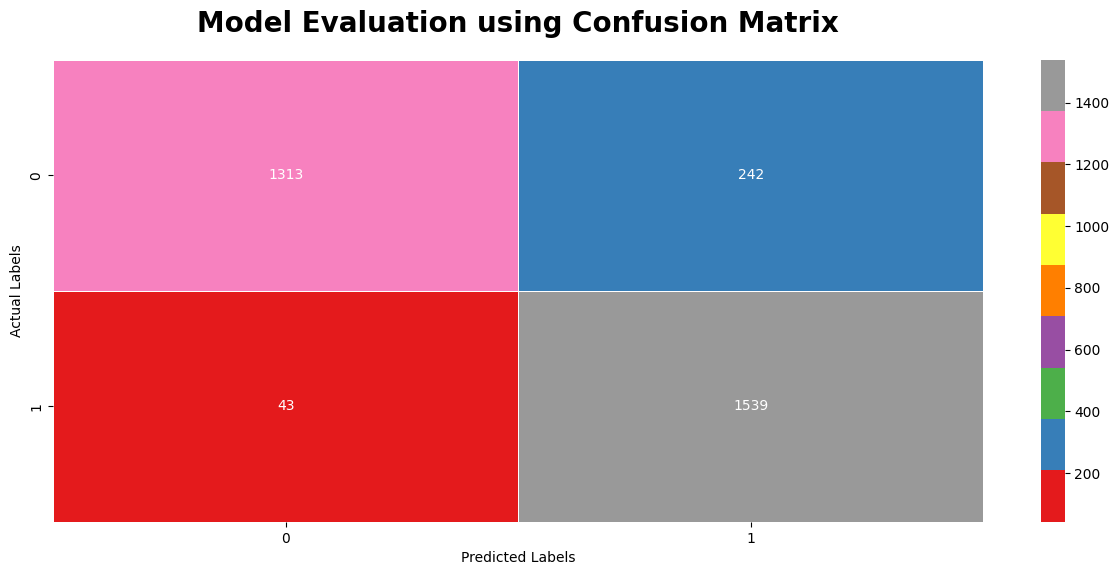

In [9]:
cm = confusion_matrix(y_test,y_test_pred_dt)

plt.figure(figsize=(15,6))
sns.heatmap(data=cm, linewidth=.5, annot=True, fmt="g", cmap="Set1")
plt.title("Model Evaluation using Confusion Matrix",fontsize=20,pad=20,fontweight="black")
plt.ylabel("Actual Labels")
plt.xlabel("Predicted Labels")
plt.show()

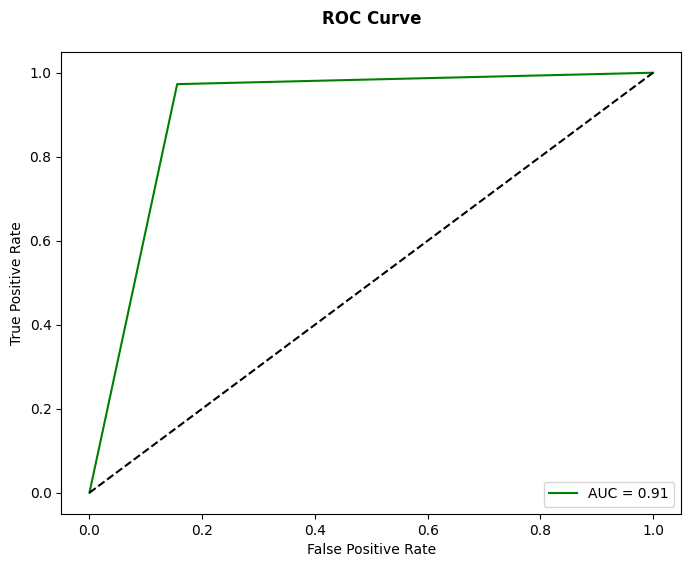

In [10]:
y_pred_proba = decision_tree.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=["y_actual"])])
df_actual_predicted.index = y_test.index


fpr, tpr, thresholds = roc_curve(df_actual_predicted["y_actual"], y_pred_proba)
auc = roc_auc_score(df_actual_predicted["y_actual"], y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}",color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve",pad=20,fontweight="black")
plt.legend()
plt.show()

## Decision Tree With Hyper parametrics tunning

Hyperparameter tuning diperlukan untuk:
- menemukan pengaturan optimal dari parameter eksternal dalam model machine learning,
- memastikan performa terbaik,
- mencegah overfitting atau underfitting,
- meningkatkan kemampuan model untuk menggeneralisasi pada data baru.

Pada tahap ini dipilih "Grid Search" karena dataset juga memiliki resource yang cukup baik, dan bisa diperoleh hyperparameter yang paling optimal

In [11]:
# Grid Search untuk menemukan parameter terbaik untuk model
dtreeh = DecisionTreeClassifier()

param_grid = {
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
    "min_samples_split": [2, 3, 4, 5, 6, 7, 8],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8],
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_features": ["sqrt", "log2", None],  # Updated max_features options
    "random_state": [0, 42]
}

grid_search = GridSearchCV(dtreeh, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8],
                         'random_state': [0, 42],
                         'splitter': ['best', 'random']})

In [12]:
# mencari parameter terbaik untuk DecisionTree
best_parameters = grid_search.best_params_

print("Parameter terbaik untuk RandomForest yaitu :\n\n")
print(best_parameters)

Parameter terbaik untuk DecisionTree Model yaitu:




{'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 0,
 'splitter': 'best'}

In [13]:
# membuat DecissionTree dengan parameter terbaik
dtreeh = DecisionTreeClassifier(**best_parameters)

dtreeh.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [14]:
# menghitung akurasi model
y_train_pred_dth = dtreeh.predict(X_train)
y_test_pred_dth = dtreeh.predict(X_test)

Accuracy Score of Model on Training Data is => 88.19 %
Accuracy Score of Model on Testing Data  is => 82.28 %


### Metric Evaluation

####  Accuracy, Precision, Recall, dan F1

In [15]:


# Menghitung dan mencetak metrik evaluasi untuk data training
acc_train_dth = round(accuracy_score(y_train, y_train_pred_dth) * 100, 2)
acc_test_dth = round(accuracy_score(y_test, y_test_pred_dth) * 100, 2)
f1_dth = round(f1_score(y_test, y_test_pred_dth, average="micro") * 100, 2)
recall_dth = round(recall_score(y_test, y_test_pred_dth, average="micro") * 100, 2)
precision_dth = round(precision_score(y_test, y_test_pred_dth, average="micro") * 100, 2)


y_score_dth = decision_tree.predict_proba(X_test)[:,1] # Menggunakan probabilitas kelas positif
roc_auc_dth = roc_auc_score(y_test, y_score_dth)

# Cross-validation
cv_scores_dth= cross_val_score(dtreeh, X_train, y_train, cv=5, scoring='accuracy')


In [16]:
print("__________________________________Hasil Evaluasi Model Decision Tree Hyper Parametrics Tunning_________________________________________________")

print("Accuracy Score of Model on Training Data is =>",acc_train_dth,"%")
print("Accuracy Score of Model on Testing Data  is =>",acc_test_dth,"%")
print("F1 Score of the Model is =>",f1_dth)
print("Recall Score of the Model is =>",recall_dth)
print("Precision Score of the Model is =>",precision_dth)
print("ROC AUC Score of the Model is =>", roc_auc_dth)
print("Cross-validation Accuracy Scores:", cv_scores_dth)
print("Mean Cross-validation Accuracy:", cv_scores_dth.mean())
print("___________________________________________________________________________________")

Accuracy Score of Model on Training Data is => 88.19 %
Accuracy Score of Model on Testing Data  is => 82.28 %
F1 Score of the Model is => 82.28
Recall Score of the Model is => 82.28
Precision Score of the Model is => 82.28
ROC AUC Score of the Model is => 0.9085961032678729
Cross-validation Accuracy Scores: [0.84176963 0.82861698 0.82781985 0.84296532 0.82861698]
Mean Cross-validation Accuracy: 0.833957752092467


- Kita dapat mengamati bahwa recall, precision, dan F1 Score semuanya sama, artinya model kita mencapai keseimbangan sempurna antara mengidentifikasi sampel positif (recall) dengan benar dan meminimalkan positif palsu (precision).
- Nilai untuk F1 score, Recall, dan Precision semuanya kurang lebih 0,7. Sehingga metric ini menunjukkan bahwa model tersebut mencapai akurasi yang baik dalam memprediksi kelas positif.

####  Confussion Matrix and ROC

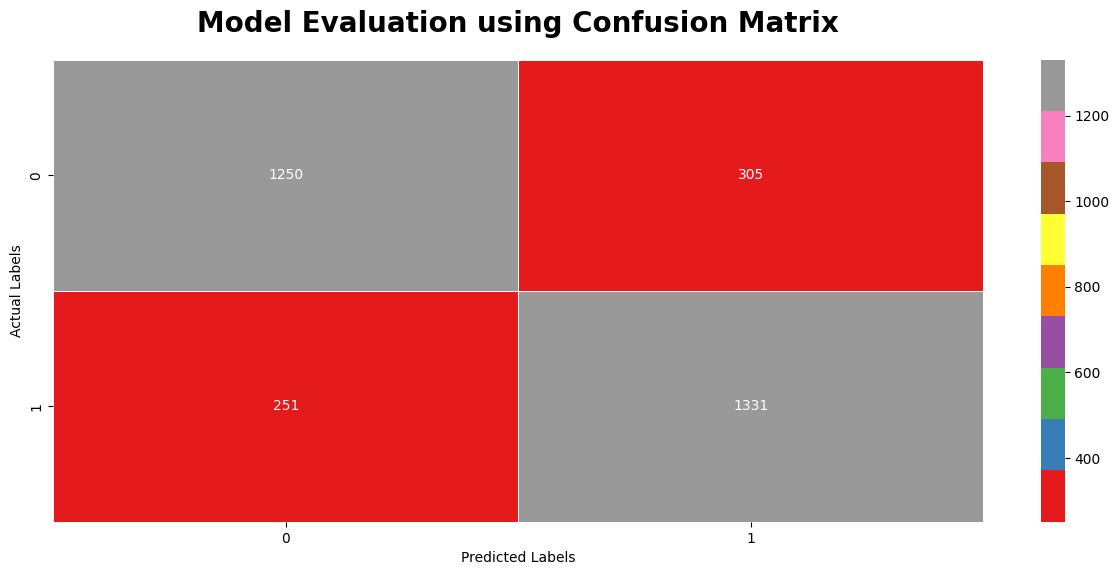

In [17]:
cm = confusion_matrix(y_test,y_test_pred_dth)

plt.figure(figsize=(15,6))
sns.heatmap(data=cm, linewidth=.5, annot=True, fmt="g", cmap="Set1")
plt.title("Model Evaluation using Confusion Matrix",fontsize=20,pad=20,fontweight="black")
plt.ylabel("Actual Labels")
plt.xlabel("Predicted Labels")
plt.show()

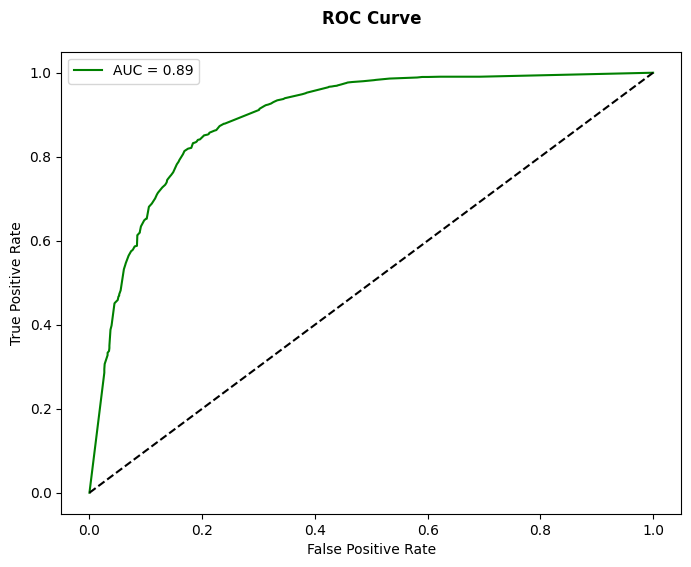

In [18]:
y_pred_proba = dtreeh.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=["y_actual"])])
df_actual_predicted.index = y_test.index


fpr, tpr, thresholds = roc_curve(df_actual_predicted["y_actual"], y_pred_proba)
auc = roc_auc_score(df_actual_predicted["y_actual"], y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}",color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve",pad=20,fontweight="black")
plt.legend()
plt.show()

In [19]:
# Menyimpan variabel-variabel ke dalam dictionary
metrics_dict = {
    'dt' :decision_tree,
    'dth' : dtreeh,
    'acc_train_dt': acc_train_dt,
    'acc_test_dt': acc_test_dt,
    'f1_dt': f1_dt,
    'recall_dt': recall_dt,
    'precision_dt': precision_dt,
    'roc_auc_dt': roc_auc_dt,
    'cv_scores_dt': cv_scores_dt,
    'acc_train_dth': acc_train_dth,
    'acc_test_dth': acc_test_dth,
    'f1_dth': f1_dth,
    'recall_dth': recall_dth,
    'precision_dth': precision_dth,
    'roc_auc_dth': roc_auc_dth,
    'cv_scores_dth': cv_scores_dt
}

# Menyimpan dictionary ke dalam file pickle
with open('DecisionTreeMetrics.pickle', 'wb') as f:
    pickle.dump(metrics_dict, f)